In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# from xgboost import XGBRegressor

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from seaborn import heatmap

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
# #Only need this to set new categories 
# df = pd.read_csv('interpolated_full.csv')

# def setCategoryValue(x): # takes an input of 'threshold' 
#     if x <= 10: 
#         return 0
#     return 1 

# df['electric_category'] = df['Percentage Electrified'].apply(lambda x: setCategoryValue(x))
# df.to_csv('labeled_data.csv')

In [70]:
df = pd.read_csv('data.csv')
for col_name in df.columns:
        if str(col_name[:7]) == 'Unnamed':
            del df[col_name]
df.head()

,CEN_2011,NAME,eH,HH,01VIIRS_10th,02VIIRS_10th,03VIIRS_10th,04VIIRS_10th,05VIIRS_10th,06VIIRS_10th,...,B10_STD_DEV,B11_STD_DEV,B2_STD_DEV,B3_STD_DEV,B4_STD_DEV,B5_STD_DEV,B6_STD_DEV,B7_STD_DEV,percentage_electrified,electric_category
0,215991.0,108102.5,214.0,339.0,0.043099,0.077040,0.170996,0.179324,0.291569,0.161928,...,0.001737,0.001726,0.027221,0.034742,0.043921,0.086157,0.054006,0.043298,0.631268,1.0
1,215992.0,108025.5,59.0,107.0,0.419949,0.381883,0.491086,0.876705,0.542789,0.226300,...,0.001196,0.001456,0.013462,0.018037,0.019069,0.087061,0.042743,0.023066,0.551402,1.0
2,215993.0,108028.5,64.0,128.0,0.204294,0.180164,0.262577,0.376620,0.400297,0.227038,...,0.001090,0.001329,0.012730,0.016276,0.017785,0.079940,0.036686,0.019230,0.500000,1.0
3,215994.0,108056.0,118.0,726.0,0.227341,0.208226,0.287490,0.129210,0.462042,0.244227,...,0.001505,0.001741,0.014410,0.019388,0.022390,0.075418,0.038113,0.028459,0.162534,1.0
4,215995.0,108222.0,449.0,615.0,0.184173,0.188419,0.242215,0.190012,0.365727,0.189305,...,0.000851,0.001157,0.008430,0.013690,0.013010,0.073827,0.033603,0.016145,0.730081,1.0


In [71]:
up_df = pd.read_csv('up_VIIRS_features.csv')
for col_name in up_df.columns:
        if str(col_name[:7]) == 'Unnamed':
            del up_df[col_name]

In [72]:
common_features = set(df.columns).intersection(up_df.columns)
len(common_features)

96

In [73]:
for col in df:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
df = df.drop_duplicates(subset = 'CEN_2011', keep = 'first')
df = df.dropna(thresh=300)
df = df.dropna(how = 'all')
df = df.dropna(how = 'all', axis = 1)
df = df[np.isfinite(df['electric_category'])]
df = df.interpolate(axis=1)
df.shape

(30457, 374)

In [74]:
# # Keep full df for later
# scaler = MinMaxScaler(feature_range=(0, 1))

# df_full = df.copy()
# all_X = df_full.drop(['Census 2011 ID', 'Percentage Electrified', 'Number of Electrified Households', 
#                       'Village Name','District Name','State Name', 'electric_category'], axis = 1)
# all_X_scaled = pd.DataFrame(scaler.transform(all_X), columns = all_X.columns)
# all_Y = df_full[['electric_category']].values 
# print (all_X_scaled.shape)

# Train test split 
df, test_data_df = train_test_split(df, test_size=0.3)
print ('Train Shape', df.shape, 'Test Shape', test_data_df.shape)
print ('Train Classes')
print (df.electric_category.value_counts())
print ('Train Classes')
print (test_data_df.electric_category.value_counts())

Train Shape (21319, 374) Test Shape (9138, 374)
Train Classes
1.0    19973
0.0     1346
Name: electric_category, dtype: int64
Train Classes
1.0    8517
0.0     621
Name: electric_category, dtype: int64


In [75]:
df0 = df[df.electric_category == 0]
df1 = df[df.electric_category == 1]

print ('Sizes before sampling: ', df1.shape, df0.shape)

df0 = resample(df0, 
                replace=True,     # sample with replacement
                n_samples=12000,  # to match majority class, Was 10000 
                random_state=123) # reproducible results. 

df1 = resample(df1, n_samples = 12000)
df = pd.concat([df1, df0])

print ('Train Shape', df.shape, 'Test Shape', test_data_df.shape)
print ('New Train Classes')
print (df.electric_category.value_counts())
print ('New Train Classes')
print (test_data_df.electric_category.value_counts())

Sizes before sampling:  (19973, 374) (1346, 374)
Train Shape (24000, 374) Test Shape (9138, 374)
New Train Classes
0.0    12000
1.0    12000
Name: electric_category, dtype: int64
New Train Classes
1.0    8517
0.0     621
Name: electric_category, dtype: int64


In [18]:
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
# Training 
X_training = df.drop(['electric_category'], axis = 1)
X_training_scaled = pd.DataFrame(scaler.fit_transform(X_training), columns = X_training.columns)
Y_training = df[['electric_category']].values

# Testing
X_testing = test_data_df.drop(['electric_category'], axis = 1)
X_testing_scaled = pd.DataFrame(scaler.transform(X_testing), columns = X_testing.columns)
Y_testing = test_data_df[['electric_category']].values

X_training_scaled.head()

,02VIIRS_75th,01VIIRS_MED,04VIIRS_MED,02VIIRS_MIN,01VIIRS_25th,12VIIRS_75th,08VIIRS_90th,03VIIRS_10th,04EVI_75th,POP_DENS_75th,...,12EVI_90th,09NDVI_MIN,02EVI_MAX,10EVI_MIN,B11_10th,B4_10th,02VIIRS_MAX,08EVI_MIN,B10_10th,04EVI_25th
0,0.006564,0.003241,0.002203,0.004226,0.003470,0.001967,0.000925,0.002682,0.389051,0.064981,...,0.447884,0.495284,0.327992,0.509479,0.535135,0.288967,0.007019,0.593901,0.577640,0.401520
1,0.035242,0.017846,0.054081,0.009008,0.019421,0.008107,0.003987,0.006831,0.268178,0.060181,...,0.298428,0.928182,0.755845,0.779808,0.567567,0.285843,0.025642,0.565674,0.552795,0.325989
2,0.007194,0.004723,0.001741,0.008084,0.005612,0.006995,0.002480,0.005680,0.262954,0.012360,...,0.465915,0.589167,0.652560,0.591709,0.578378,0.380360,0.008186,0.621233,0.453416,0.303089
3,0.018903,0.030508,0.013872,0.019000,0.026564,0.017059,0.007613,0.018268,0.402110,0.013110,...,0.316749,0.609328,0.574987,0.729214,0.459460,0.407797,0.015412,0.499552,0.279503,0.433176
4,0.006852,0.007691,0.002746,0.010419,0.008821,0.003374,0.002039,0.006830,0.470644,0.004740,...,0.306142,0.490958,0.476655,0.509822,0.594595,0.354094,0.004856,0.720475,0.621118,0.502742


In [19]:
X_training_scaled.shape

(24000, 51)

In [20]:
X_train = X_training_scaled
Y_train = Y_training.ravel()
X_test = X_testing_scaled

In [16]:
# pca = PCA(n_components=100)
# pca.fit(X_training_scaled)
# X_training_scaled = pca.transform(X_training_scaled)
# X_training_scaled.shape

In [17]:
# print(pca.explained_variance_ratio_)  

In [21]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, Y_train) 
melb_preds = forest_model.predict(X_test)

In [22]:
print ('The accuracy is {}, with {} villages correctly classified.'.format(accuracy_score(Y_testing,melb_preds), 
                                                        accuracy_score(Y_testing, melb_preds, normalize=False)))

The accuracy is 0.8968045524184723, with 8195 villages correctly classified.


In [15]:
test_data_df['predictions'] = melb_preds
test_data_df.head()

,Census 2011 ID,Village Name,District Name,State Name,Number of Households,Number of Electrified Households,Percentage Electrified,min,10th_percentile,median,...,rain_may_90th,rain_jun_90th,rain_jul_90th,rain_aug_90th,rain_sep_90th,rain_oct_90th,rain_nov_90th,rain_dec_90th,electric_category,predictions
14763,237275,Ghosd Ahabanpur,Samastipur,Bihar,152.0,10.0,6.578947,0.210984,0.227739,0.241533,...,201.281799,135.005600,269.214386,188.122604,327.114594,76.542801,0.0,0.0000,0,0
10734,229559,Chamrahra urf Lalpur,Muzaffarpur,Bihar,362.0,317.0,87.569061,0.539362,0.552147,0.711388,...,318.030212,159.403992,244.636993,150.876190,214.521988,42.013798,0.0,0.0000,1,1
12281,234737,Jarang Rampur,Vaishali,Bihar,357.0,252.0,70.588235,0.722869,0.743632,1.004954,...,306.500000,176.862396,273.881989,164.663193,245.289993,67.594398,0.0,0.0000,1,1
30101,254047,Mahdewa,Aurangabad,Bihar,90.0,17.0,18.888889,0.518291,0.518291,0.679025,...,82.528397,206.650192,281.338776,281.045197,561.862183,73.131195,0.0,0.6182,1,0
10232,233023,Hasanpur Bina,Saran,Bihar,122.0,84.0,68.852459,0.193255,0.225636,0.321392,...,245.207001,143.939590,265.574005,177.763397,190.477997,100.190598,0.0,0.0000,1,1


In [16]:
X_train.shape

(24000, 339)

In [17]:
X_test.shape

(6679, 339)

In [27]:
# Test on Training Data 
# stochastic gradient descent (SGD) learning
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)


print(round(acc_sgd,2,), "%")

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(round(acc_log,2,), "%")

# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(round(acc_knn,2,), "%")

# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(round(acc_gaussian,2,), "%")

# Perceptron
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
print(round(acc_perceptron,2,), "%")

# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(round(acc_linear_svc,2,), "%")

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

63.42 %
100.0 %
64.6 %
96.78 %
53.92 %
50.01 %
64.85 %
100.0 %


In [31]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
93.66,Perceptron
92.56,Random Forest
84.01,Decision Tree
77.94,KNN
61.67,Logistic Regression
61.25,Support Vector Machines
56.75,Stochastic Gradient Decent
17.38,Naive Bayes


In [32]:
# Test on Testing Data 
# stochastic gradient descent (SGD) learning
acc_sgd = round(sgd.score(X_test, Y_testing) * 100, 2)
print(round(acc_sgd,2,), "%")

# Random Forest
acc_random_forest = round(random_forest.score(X_test, Y_testing) * 100, 2)
print(round(acc_random_forest,2,), "%")

# Logistic Regression
acc_log = round(logreg.score(X_test, Y_testing) * 100, 2)
print(round(acc_log,2,), "%")

# KNN
acc_knn = round(knn.score(X_test, Y_testing) * 100, 2)
print(round(acc_knn,2,), "%")

# Gaussian Naive Bayes
acc_gaussian = round(gaussian.score(X_test, Y_testing) * 100, 2)
print(round(acc_gaussian,2,), "%")

# Perceptron
acc_perceptron = round(perceptron.score(X_test, Y_testing) * 100, 2)
print(round(acc_perceptron,2,), "%")

# Linear SVC
acc_linear_svc = round(linear_svc.score(X_test, Y_testing) * 100, 2)
print(round(acc_linear_svc,2,), "%")

# Decision Tree
acc_decision_tree = round(decision_tree.score(X_test, Y_testing) * 100, 2)
print(round(acc_decision_tree,2,), "%")

56.75 %
92.56 %
61.67 %
77.94 %
17.38 %
93.66 %
61.25 %
84.01 %


In [33]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
93.66,Perceptron
92.56,Random Forest
84.01,Decision Tree
77.94,KNN
61.67,Logistic Regression
61.25,Support Vector Machines
56.75,Stochastic Gradient Decent
17.38,Naive Bayes


In [22]:
# K fold cross validation 
c, r = Y_testing.shape
Y_testing = Y_testing.reshape(c,)

rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_test, Y_testing, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Average Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.93124066  0.93423019  0.93273543  0.93572496  0.93413174  0.93253373
  0.93553223  0.93103448  0.93553223  0.93103448]
Average Accuracy: 0.93337301436
Standard Deviation: 0.00181002354388


In [62]:
gb = GradientBoostingClassifier(n_estimators=15, learning_rate = .46, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, Y_train)
predictions = gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(Y_testing, predictions))
print()
print("Classification Report")
print(classification_report(Y_testing, predictions))

Confusion Matrix:
[[ 382  198]
 [2797 5761]]

Classification Report
             precision    recall  f1-score   support

        0.0       0.12      0.66      0.20       580
        1.0       0.97      0.67      0.79      8558

avg / total       0.91      0.67      0.76      9138



In [61]:
estimators = np.arange(5, 50, 5)
learning_rates = np.arange(.01, 2, .05)
d = {}
for es in estimators: 
    for lr in learning_rates:
        gb = GradientBoostingClassifier(n_estimators=es, learning_rate = lr, max_features=2, max_depth = 2, random_state = 0)
        gb.fit(X_train, Y_train)
        predictions = gb.predict(X_test)
        d[str(es) + ' ' + str(lr)] = confusion_matrix(Y_testing, predictions)[0][0]
sorted(d.items(), key=lambda x:x[1])

[('45 1.86', 298),
 ('5 1.81', 305),
 ('10 1.81', 306),
 ('40 1.76', 307),
 ('40 1.6600000000000001', 308),
 ('40 1.86', 311),
 ('45 1.6600000000000001', 312),
 ('10 1.9600000000000002', 314),
 ('35 1.6600000000000001', 314),
 ('35 1.76', 315),
 ('45 1.76', 315),
 ('30 1.9600000000000002', 316),
 ('40 1.51', 316),
 ('30 1.86', 317),
 ('45 1.9600000000000002', 319),
 ('35 1.9600000000000002', 321),
 ('40 1.9600000000000002', 322),
 ('20 1.76', 323),
 ('35 1.9100000000000001', 323),
 ('5 1.9600000000000002', 324),
 ('30 1.76', 324),
 ('35 1.51', 324),
 ('30 1.51', 325),
 ('35 1.86', 325),
 ('45 1.36', 325),
 ('45 1.51', 325),
 ('45 1.81', 325),
 ('25 1.61', 326),
 ('30 1.81', 326),
 ('40 1.81', 326),
 ('40 1.9100000000000001', 326),
 ('40 1.61', 327),
 ('45 1.4100000000000001', 327),
 ('45 1.4600000000000002', 327),
 ('30 1.36', 328),
 ('40 0.01', 328),
 ('45 0.01', 328),
 ('45 1.61', 328),
 ('45 1.7100000000000002', 328),
 ('45 1.9100000000000001', 328),
 ('5 1.9100000000000001', 329),


In [23]:
# K fold cross validation 
c, r = Y_training.shape
Y_training = Y_training.reshape(c,)

rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_training, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Average Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.98875     0.98791667  0.985       0.98833333  0.98625     0.98375
  0.98541667  0.98333333  0.98833333  0.98375   ]
Average Accuracy: 0.986083333333
Standard Deviation: 0.00201728640615


In [34]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [35]:
importances.head(10)

,importance
feature,
02VIIRS_75th,0.035
02VIIRS_90th,0.025
04EVI_75th,0.025
03VIIRS_10th,0.024
02VIIRS_10th,0.024
11VIIRS_MED,0.024
01VIIRS_MED,0.023
02VIIRS_MIN,0.023
B4_10th,0.022


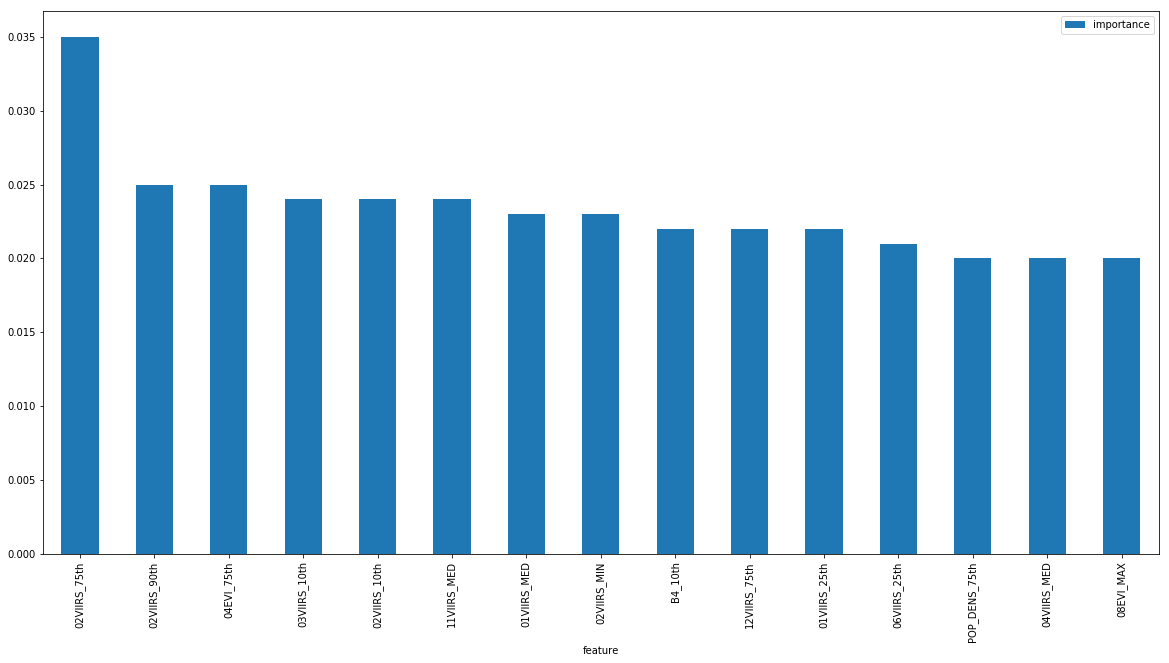

In [36]:
importances.head(15).plot.bar(figsize=(20,10))

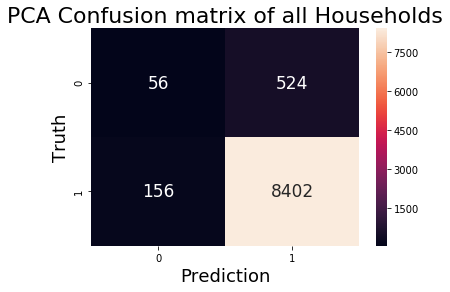

In [37]:
def plot_confusion_matrix(title): 
    predictions = random_forest.predict(X_test)
    conf_matrix = confusion_matrix(Y_testing, predictions)
    heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size":17})
    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Truth', fontsize=18)
    plt.title(title, fontsize=22)
    plt.show()
    
plot_confusion_matrix('PCA Confusion matrix of all Households')

In [28]:
predictions = random_forest.predict(X_test)

In [29]:
# F-Score
from sklearn.metrics import f1_score
f1_score(Y_testing, predictions)

0.9547619047619047

In [30]:
# Precision and Recall
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_testing, predictions))
print("Recall:",recall_score(Y_testing, predictions))

Precision: 0.945011783189
Recall: 0.96471531676


In [31]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_test)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_testing, y_scores)

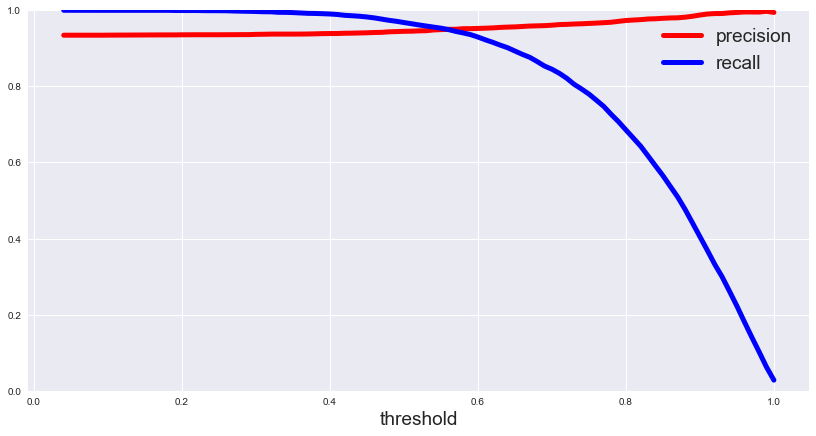

In [32]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

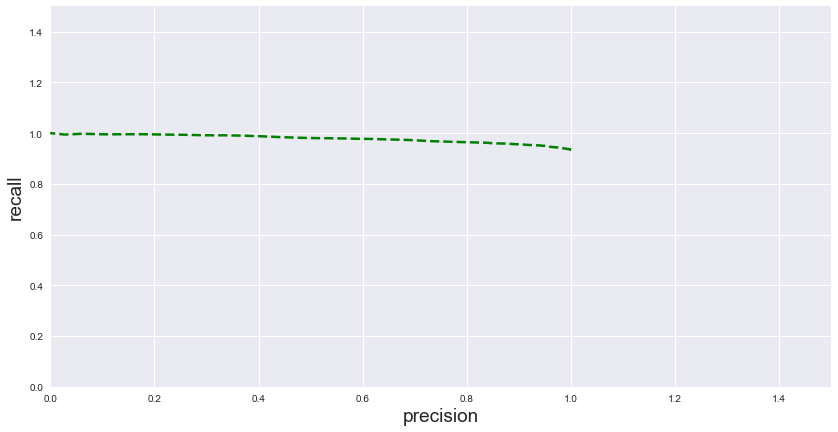

In [33]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

In [34]:
# ROC AUC Curve
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_testing, y_scores)

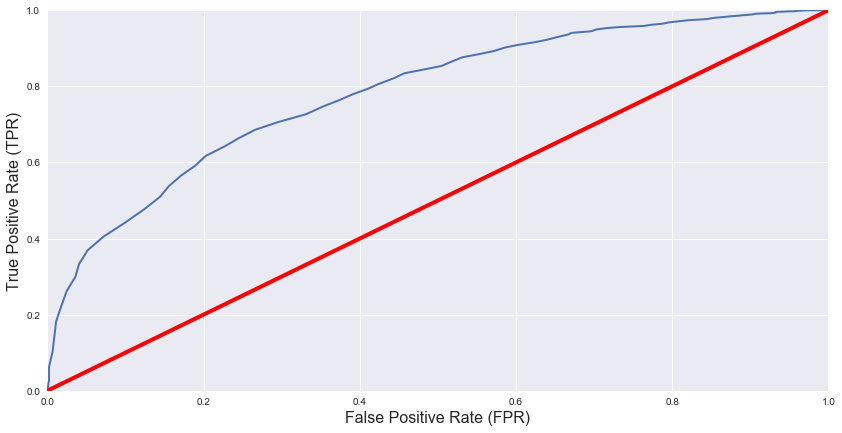

In [35]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_testing, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.782487338983
